In [3]:
# Import Python modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from category_encoders import BinaryEncoder
from sklearn.feature_selection import RFE, VarianceThreshold, SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from functools import partial

import xgboost as xgb

import pickle

### Exploratory Data Analysis
   - Check the distribution or frequency of every feature, identify outliers.
   - For additional analysis and initial preprocessing steps please refor to: `vaccines.ipynb`.

In [4]:
# Read ML file
file_path = './data/vax_trials_ml_df.csv'
df_ml = pd.read_csv(file_path)

# Display the DataFrame
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,1.0,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,3.0,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,349.0,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,119.0,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,140.0,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000


In [5]:
df_ml.describe()

,enrollment,actual_duration,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq
count,997.000000,997.000000,997.000000,997.000000,997.000000,997.000000,9.970000e+02,9.970000e+02,997.000000,997.000000,997.000000,997.000000
mean,1160.324975,20.967904,9.152208,34.001846,386.036108,1968.281846,1.957594e+05,6.059783e+04,0.283318,3.083759,35.151842,53.813923
std,4147.738651,23.621449,15.659109,10.729662,2203.699966,4415.426753,1.456521e+06,3.996762e+05,0.721446,3.748698,83.417282,151.411402
min,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,101.000000,7.000000,1.055409,33.500000,1.000000,119.000000,8.400000e+01,1.155000e+03,0.004184,0.884000,1.000000,8.000000
50%,312.000000,14.000000,3.809524,33.899366,10.000000,522.000000,2.112000e+03,4.323000e+03,0.032895,2.171429,7.000000,14.000000
75%,793.000000,25.000000,9.800520,41.000000,82.000000,2009.000000,2.030900e+04,1.632900e+04,0.194401,3.902954,30.968889,32.000000
max,84496.000000,255.000000,120.863793,75.000000,50684.000000,58645.000000,2.438349e+07,7.668954e+06,7.351852,55.376392,899.527633,1747.847619


In [6]:
df_ml.dtypes

nct_id                            object
phase                             object
enrollment                       float64
condition_name                    object
actual_duration                  float64
gender                            object
country                           object
agency_class                      object
dropout_rate                     float64
mean_age_imp                     float64
AE_total_serious                 float64
AE_total_other                   float64
subjects_at_risk_serious         float64
subjects_at_risk_other           float64
AE_serious_freq                  float64
AE_other_freq                    float64
subjects_at_risk_serious_freq    float64
subjects_at_risk_other_freq      float64
dtype: object

In [7]:
# Count the number of missing values in each column
na_counts = df_ml.isna().sum()
print(na_counts)

nct_id                           0
phase                            0
enrollment                       0
condition_name                   0
actual_duration                  0
gender                           0
country                          0
agency_class                     0
dropout_rate                     0
mean_age_imp                     0
AE_total_serious                 0
AE_total_other                   0
subjects_at_risk_serious         0
subjects_at_risk_other           0
AE_serious_freq                  0
AE_other_freq                    0
subjects_at_risk_serious_freq    0
subjects_at_risk_other_freq      0
dtype: int64


Visualize numeric features using histograms and box plots

In [8]:
# define function to add a boxplot on top of a histogram
def creating_box_hist(column, df, bin):
    # Create a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})    

    # Assigning a graph to each ax
    sns.boxplot(x=column, data=df, ax=ax_box, color='blueviolet', flierprops=dict(marker='o', markerfacecolor='darkgray'))
    sns.histplot(data=df, x=column, ax=ax_hist, bins=bin, color='blueviolet', kde=True)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.show()

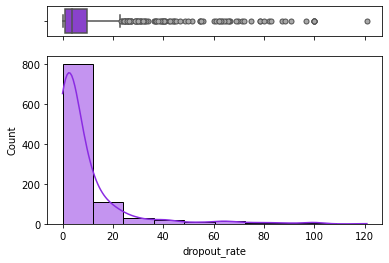

In [9]:
# Plot dropout rate
creating_box_hist('dropout_rate', df_ml, 10)

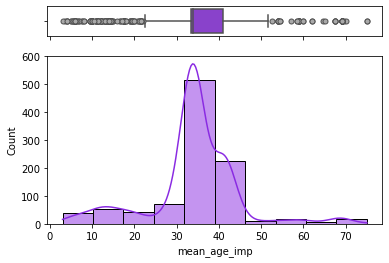

In [10]:
# Plot age
creating_box_hist('mean_age_imp', df_ml, 10)

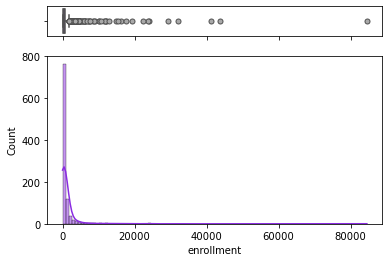

In [11]:
# Plot enrollment
creating_box_hist('enrollment', df_ml, 100)

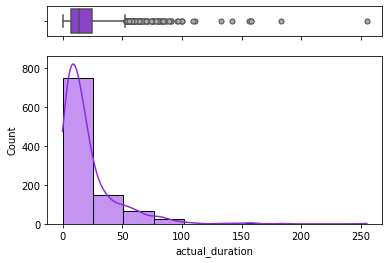

In [12]:
# Plot duration
creating_box_hist('actual_duration', df_ml, 10)

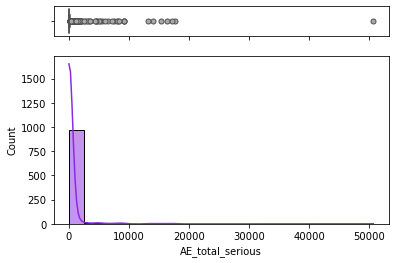

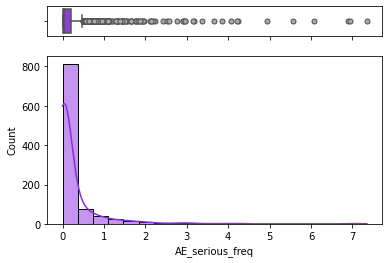

In [13]:
# Plot number of serious adverse events 
creating_box_hist('AE_total_serious', df_ml, 20)
creating_box_hist('AE_serious_freq', df_ml, 20)

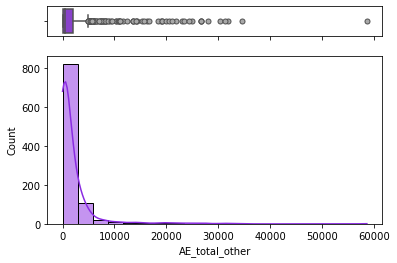

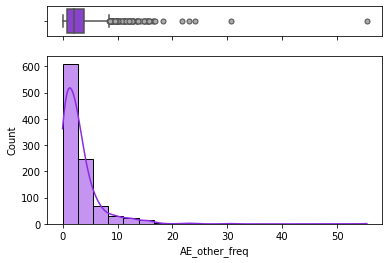

In [14]:
# Plot number of other types of adverse events 
creating_box_hist('AE_total_other', df_ml, 20)
creating_box_hist('AE_other_freq', df_ml, 20)

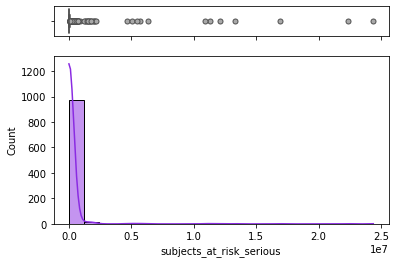

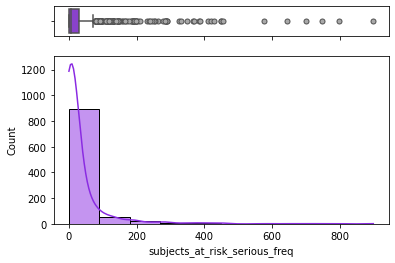

In [15]:
# Plot number of subjects at risk of having a serious adverse events 
creating_box_hist('subjects_at_risk_serious', df_ml, 20)
creating_box_hist('subjects_at_risk_serious_freq', df_ml, 10)

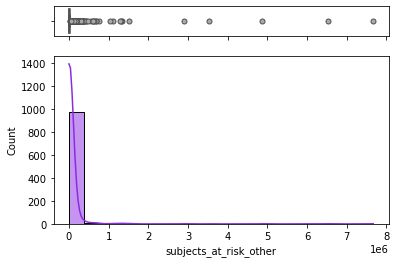

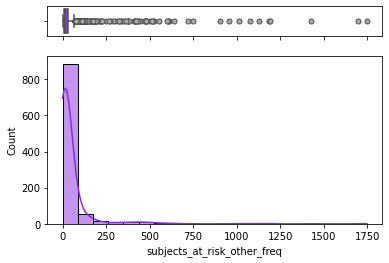

In [16]:
# Plot number of subjects at risk of having other types adverse events 
creating_box_hist('subjects_at_risk_other', df_ml, 20)
creating_box_hist('subjects_at_risk_other_freq', df_ml, 20)

Visualize categorical variables using count plot

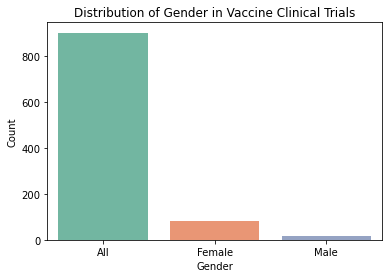

In [17]:
# Plot a countplot:
sns.countplot(x='gender', data=df_ml, palette='Set2')
plt.title('Distribution of Gender in Vaccine Clinical Trials')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

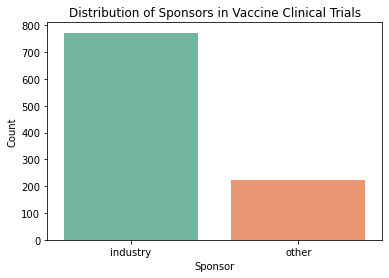

In [18]:
# Plot a countplot: agency class
sns.countplot(x='agency_class', data=df_ml, palette='Set2')
plt.title('Distribution of Sponsors in Vaccine Clinical Trials')
plt.xlabel('Sponsor')
plt.ylabel('Count')
plt.show()

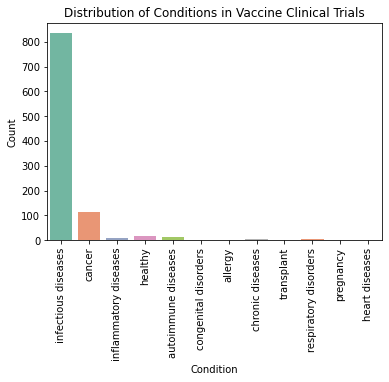

In [19]:
# Plot a countplot: condition name
sns.countplot(x='condition_name', data=df_ml, palette='Set2')
plt.title('Distribution of Conditions in Vaccine Clinical Trials')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

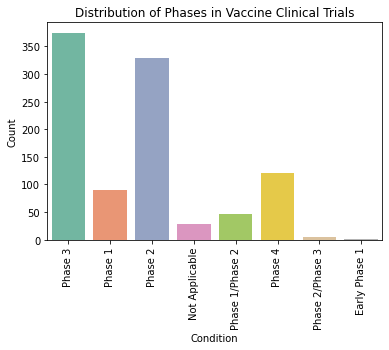

In [20]:
# Plot a countplot: phase
sns.countplot(x='phase', data=df_ml, palette='Set2')
plt.title('Distribution of Phases in Vaccine Clinical Trials')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

### Preprocessing the Data for Machine Learning Models

1. **Data Encoding:**
   - Encode categorical variables into numerical representations using techniques like one-hot encoding, label encoding binary enconding.

2. **Normalization and Scaling:**
   - Normalize or scale numerical features to ensure uniformity and improve model performance. 
   - Important for distance-based algorithms (eg. KNN) and regularization methods (L1 and L2).

3. **Feature Selection Methods**
    - Techniques include: filter, wrapper, and embedded methods.

4. **Data Splitting:**
   - Split the dataset into training and testing sets for machine learning models.

- Data encoding: 

    - phase
    - gender
    - agency_class
    - country


In [21]:
# Define mapping for phase categories to numerical values
phase_mapping = {
    'Early Phase 1': 1,
    'Phase 1': 2,
    'Phase 1/Phase 2': 3,
    'Phase 2': 4,
    'Phase 2/Phase 3': 5,
    'Phase 3': 6,
    'Phase 4': 7,
    'Not Applicable': 0
}

# Map the 'phase' column to numerical values
df_ml['phase_encoded'] = df_ml['phase'].map(phase_mapping)

# Display df
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq,phase_encoded
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,1.0,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333,6
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,3.0,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000,2
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,349.0,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210,4
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,119.0,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009,6
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,140.0,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000,4


In [22]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the 'gender' column
df_ml['gender_encoded'] = le.fit_transform(df_ml['gender'])

# Display the DataFrame with the new column
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq,phase_encoded,gender_encoded
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,1.0,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333,6,0
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,3.0,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000,2,0
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,349.0,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210,4,0
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,119.0,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009,6,0
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,140.0,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000,4,0


In [23]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the 'agency_class' column
df_ml['agency_class_encoded'] = le.fit_transform(df_ml['agency_class'])

# Display the DataFrame with the new column
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,...,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq,phase_encoded,gender_encoded,agency_class_encoded
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,...,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333,6,0,0
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,...,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000,2,0,1
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,...,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210,4,0,0
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,...,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009,6,0,0
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,...,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000,4,0,0


In [24]:
# Drop 'phase','gender', angency_class columns
df_ml = df_ml.drop(['phase', 'gender', 'agency_class'], axis=1)

# Display the DataFrame with the new column
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,country,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq,phase_encoded,gender_encoded,agency_class_encoded
0,NCT00444951,450.0,infectious diseases,12.0,saudi arabia,3.111111,17.500000,1.0,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333,6,0,0
1,NCT00623831,17.0,cancer,60.0,germany,11.764706,41.500000,3.0,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000,2,0,1
2,NCT00434577,715.0,infectious diseases,7.0,multiple,1.818182,33.899366,349.0,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210,4,0,0
3,NCT00616421,2907.0,infectious diseases,13.0,multiple,3.611971,6.000000,119.0,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009,6,0,0
4,NCT04515147,668.0,infectious diseases,17.0,multiple,8.532934,41.500000,140.0,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000,4,0,0


In [25]:
# Encode the 'country' column
df_ml = BinaryEncoder(cols=['country']).fit(df_ml).transform(df_ml)

# Display the DataFrame with the new column
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,country_0,country_1,country_2,country_3,country_4,country_5,...,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq,phase_encoded,gender_encoded,agency_class_encoded
0,NCT00444951,450.0,infectious diseases,12.0,0,0,0,0,0,1,...,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333,6,0,0
1,NCT00623831,17.0,cancer,60.0,0,0,0,0,1,0,...,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000,2,0,1
2,NCT00434577,715.0,infectious diseases,7.0,0,0,0,0,1,1,...,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210,4,0,0
3,NCT00616421,2907.0,infectious diseases,13.0,0,0,0,0,1,1,...,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009,6,0,0
4,NCT04515147,668.0,infectious diseases,17.0,0,0,0,0,1,1,...,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000,4,0,0


#### Feature selection methods

Filter methods

- Variance threshold: to remove any features that have little to no variation in their values.
- Pearson’s correlation: measuring the linear relationship between two numeric, continuous variables. Correlation between features, and correlation between features and target.
- F-statistic: correlation between features and target.
- Mutual information: measures the dependence between two variables and can be used to estimate how much a feature contributes to the prediction of the target variable.

In [26]:
# features
features = df_ml.drop(['nct_id', 'condition_name', 'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5',
                       'phase_encoded', 'gender_encoded', 'agency_class_encoded', 'dropout_rate'], axis=1)

# target variable
target = df_ml['dropout_rate']

In [27]:
# Variance threshold
selector = VarianceThreshold(threshold=0)  # 0 is default
print(selector.fit_transform(features))

[[4.50000000e+02 1.20000000e+01 1.75000000e+01 ... 2.40444444e+00
  9.88888889e-01 6.81333333e+00]
 [1.70000000e+01 6.00000000e+01 4.15000000e+01 ... 5.88235294e+00
  3.00000000e+00 6.70000000e+01]
 [7.15000000e+02 7.00000000e+00 3.38993661e+01 ... 2.40000000e+00
  2.03714685e+02 6.99020979e+00]
 ...
 [3.00000000e+02 7.00000000e+00 3.35000000e+01 ... 1.40000000e-01
  3.00000000e+00 1.30000000e+01]
 [1.44700000e+03 1.20000000e+01 1.70000000e+01 ... 3.93849343e+00
  6.60000000e+01 1.09723566e+01]
 [4.80000000e+01 3.00000000e+00 3.38993661e+01 ... 5.16666667e+00
  6.00000000e+00 7.79166667e+01]]


In [28]:
# Use indices to get the corresponding column names of selected features
num_cols = list(features.columns[selector.get_support(indices=True)])
print(num_cols)

['enrollment', 'actual_duration', 'mean_age_imp', 'AE_total_serious', 'AE_total_other', 'subjects_at_risk_serious', 'subjects_at_risk_other', 'AE_serious_freq', 'AE_other_freq', 'subjects_at_risk_serious_freq', 'subjects_at_risk_other_freq']


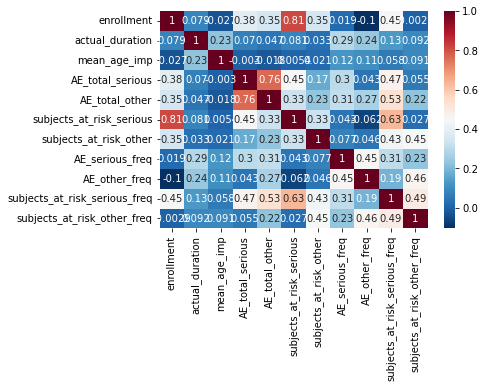

In [29]:
# Pearson’s correlation: 
# Correlation between features: drop highly correlated features to avoid duplicate information.

corr_matrix = features.corr(method='pearson') 

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

In [30]:
# Correlation between features and target

X_y = features.copy()
X_y['dropout_rate'] = target

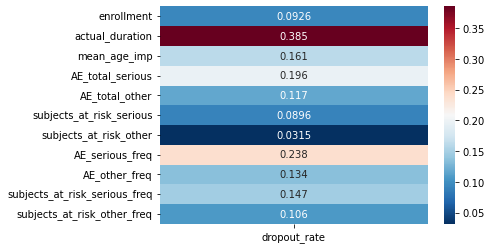

In [31]:
corr_matrix = X_y.corr()

# Isolate the column corresponding to 'dropout'
corr_target = corr_matrix[['dropout_rate']].drop(labels=['dropout_rate'])

sns.heatmap(corr_target, annot=True, fmt='.3', cmap='RdBu_r')
plt.show()

In [32]:
# F-statistic: correlation between features and target
# The F-statistic will be larger (and p-value will be smaller) for predictors that are more highly correlated with the target variable
# First array: F-statistic
# Second array: p-value

print(f_regression(features, target))

(array([  8.60312975, 173.27695458,  26.48230427,  39.90765647,
        13.70198793,   8.04566117,   0.98801421,  59.74816589,
        18.25417154,  22.04145067,  11.3934159 ]), array([3.43280514e-03, 1.34213986e-36, 3.20359371e-07, 4.00889249e-10,
       2.25984124e-04, 4.65381495e-03, 3.20469863e-01, 2.62919313e-14,
       2.11851018e-05, 3.04192301e-06, 7.65532421e-04]))


In [33]:
# features
features = df_ml.drop(['nct_id', 'condition_name', 'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5','dropout_rate'], axis=1)
features.head()

,enrollment,actual_duration,mean_age_imp,AE_total_serious,AE_total_other,subjects_at_risk_serious,subjects_at_risk_other,AE_serious_freq,AE_other_freq,subjects_at_risk_serious_freq,subjects_at_risk_other_freq,phase_encoded,gender_encoded,agency_class_encoded
0,450.0,12.0,17.500000,1.0,1082.0,445.0,3066.0,0.002222,2.404444,0.988889,6.813333,6,0,0
1,17.0,60.0,41.500000,3.0,100.0,51.0,1139.0,0.176471,5.882353,3.000000,67.000000,2,0,1
2,715.0,7.0,33.899366,349.0,1716.0,145656.0,4998.0,0.488112,2.400000,203.714685,6.990210,4,0,0
3,2907.0,13.0,6.000000,119.0,4625.0,69144.0,51858.0,0.040936,1.590987,23.785346,17.839009,6,0,0
4,668.0,17.0,41.500000,140.0,3398.0,10020.0,18036.0,0.209581,5.086826,15.000000,27.000000,4,0,0


In [34]:
# Mutual information

# features
features = df_ml.drop(['nct_id', 'condition_name', 'dropout_rate'], axis=1)

# target variable
target = df_ml['dropout_rate']

print(mutual_info_regression(features, target, discrete_features=[11,12,13], random_state=68))

[0.20694377 0.17851112 0.         0.00293911 0.         0.00314686
 0.04147552 0.03534199 0.03800043 0.09850034 0.08192192 0.
 0.01960093 0.01041031 0.         0.11520945 0.02147017 0.02154608
 0.03592117 0.03863665]


In [35]:
score_func = partial(mutual_info_regression, discrete_features=[11,12,13], random_state=68)

# Select top 5 features with the most mutual information
selection = SelectKBest(score_func=score_func, k=5)

print(selection.fit_transform(features, target))

[[4.50000000e+02 1.20000000e+01 1.00000000e+00 1.08200000e+03
  9.88888889e-01]
 [1.70000000e+01 6.00000000e+01 3.00000000e+00 1.00000000e+02
  3.00000000e+00]
 [7.15000000e+02 7.00000000e+00 3.49000000e+02 1.71600000e+03
  2.03714685e+02]
 ...
 [3.00000000e+02 7.00000000e+00 3.00000000e+00 4.20000000e+01
  3.00000000e+00]
 [1.44700000e+03 1.20000000e+01 9.30000000e+01 5.69900000e+03
  6.60000000e+01]
 [4.80000000e+01 3.00000000e+00 6.00000000e+00 2.48000000e+02
  6.00000000e+00]]


In [36]:
X = features[features.columns[selection.get_support(indices=True)]]
print(X)

     enrollment  actual_duration  AE_total_serious  AE_total_other  \
0         450.0             12.0               1.0          1082.0   
1          17.0             60.0               3.0           100.0   
2         715.0              7.0             349.0          1716.0   
3        2907.0             13.0             119.0          4625.0   
4         668.0             17.0             140.0          3398.0   
..          ...              ...               ...             ...   
992       406.0             19.0               0.0           169.0   
993        50.0             56.0              38.0           123.0   
994       300.0              7.0               3.0            42.0   
995      1447.0             12.0              93.0          5699.0   
996        48.0              3.0               6.0           248.0   

     subjects_at_risk_serious_freq  
0                         0.988889  
1                         3.000000  
2                       203.714685  
3          

One-Hot Encoding:

- dummy variables are created to handle categorical variables. They transform each category within a variable into its own binary identifier.
- disadvantage: it can lead to a high-dimensional feature space if there are many unique diseases, so it may not be efficient for large datasets.

In [37]:
# Create dummy variables for 'condition_name' 
df_ml = pd.get_dummies(df_ml, columns=['condition_name'], prefix=['condition'])
df_ml.head()

,nct_id,enrollment,actual_duration,country_0,country_1,country_2,country_3,country_4,country_5,dropout_rate,...,condition_cancer,condition_chronic diseases,condition_congenital disorders,condition_healthy,condition_heart diseases,condition_infectious diseases,condition_inflammatory diseases,condition_pregnancy,condition_respiratory disorders,condition_transplant
0,NCT00444951,450.0,12.0,0,0,0,0,0,1,3.111111,...,0,0,0,0,0,1,0,0,0,0
1,NCT00623831,17.0,60.0,0,0,0,0,1,0,11.764706,...,1,0,0,0,0,0,0,0,0,0
2,NCT00434577,715.0,7.0,0,0,0,0,1,1,1.818182,...,0,0,0,0,0,1,0,0,0,0
3,NCT00616421,2907.0,13.0,0,0,0,0,1,1,3.611971,...,0,0,0,0,0,1,0,0,0,0
4,NCT04515147,668.0,17.0,0,0,0,0,1,1,8.532934,...,0,0,0,0,0,1,0,0,0,0


#### Recursive Feature Elimination

In [38]:
# Select variables
x = df_ml.drop(['nct_id', 'dropout_rate'], axis=1)
y = df_ml['dropout_rate']

In [39]:
# Get feature names
features = x.columns

# Create a linear regression model
lm = LinearRegression()

# Standardize the data
x = pd.DataFrame(StandardScaler().fit_transform(x))

# Create a recursive feature elimination model
rfe = RFE(estimator=lm, n_features_to_select=6)

# Fit the recursive feature elimination model to x and y
rfe.fit(x, y)

# Print the model accuracy after doing recursive feature elimination
print(rfe.score(x, y))

# See which features recursive feature elimination chose
rfe_features = [f for (f, support) in zip(features, rfe.support_) if support]
print(rfe_features)

0.2373339954499002
['actual_duration', 'AE_total_serious', 'subjects_at_risk_serious', 'subjects_at_risk_serious_freq', 'condition_autoimmune diseases', 'condition_cancer']


In [40]:
# Select variables
x = df_ml.drop(['nct_id', 'dropout_rate'], axis=1)
y = df_ml['dropout_rate']

In [41]:
# Get feature names
features = x.columns

# Create a random forest regression model
rfr = RandomForestRegressor()

# Create a recursive feature elimination model
rfe = RFE(estimator=rfr, n_features_to_select=6)

# Fit the recursive feature elimination model to x and y
rfe.fit(x, y)

# Print the model accuracy after doing recursive feature elimination
print(rfe.score(x, y))

# See which features recursive feature elimination chose
rfe_features = [f for (f, support) in zip(features, rfe.support_) if support]
print(rfe_features)

0.8819138560311781
['enrollment', 'actual_duration', 'AE_total_serious', 'AE_serious_freq', 'AE_other_freq', 'subjects_at_risk_other_freq']


#### Select Variables

The data for the model will consist of a subset of variables. The **x** dataframe will contain features that could serve as good predictors for patient dropout in clinical trials. The **y** dataframe will include the target column, denoted by the 'dropout_rate', indicating the percentage of dropouts per clinical trial.

In [42]:
# # Select variables
# x = df_ml[['enrollment', 'actual_duration', 'AE_total_serious', 'subjects_at_risk_other_freq', 'phase_encoded', 'mean_age_imp']]
# y = df_ml['dropout_rate']

In [43]:
# Select variables
x = df_ml[['enrollment', 'actual_duration', 'AE_total_serious', 'subjects_at_risk_other_freq' ,'mean_age_imp', 'phase_encoded']]
y = df_ml['dropout_rate']

In [44]:
# Standardize the data using StandardScaler
standard_scaler = StandardScaler()
x_scaled = standard_scaler.fit_transform(x)

In [45]:
# Standardize the data using RobustScaler
robust_scaler = RobustScaler()
x_robust = robust_scaler.fit_transform(x)

#### Splitting the Data

- In this split, 20% of the data is reserved for final validation, while 80% is allocated for training the model.

In [46]:
# Splitting the data

#Validation chunk size
val_size = 0.20

#Split the data into chunks
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=val_size, random_state = 42)

#Split the standard scaled data into chunks
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(x_scaled, y, test_size=val_size, random_state = 42)

#Split the robust scaled data into chunks
x_train_robust, x_test_robust, y_train_robust, y_test_robust = train_test_split(x_robust, y, test_size=val_size, random_state = 42)

#### Prediction

- **Model Building:** for this project, five algorithms will be used to make predictions:

  1. Linear Regression
  2. K Nearest Neighbor
  3. Decision Trees
  4. Random Forests
  5. XGBoost

- **Evaluation Metrics:**
  - Mean Squared Error (MSE)
  - Root Mean Squared Error (RMSE)
  - Mean Absolute Error (MAE)
  - R-squared (R2)

##### Multiple Linear Regression

In [47]:
# Initialize and train a linear regression model
lm = LinearRegression()
lm.fit(x_train_robust, y_train_robust)

# Make predictions on the test set
y_pred = lm.predict(x_test_robust)

In [48]:
# Print coeficients and intercept
print("Coefficients of each feature:", lm.coef_)
print("Intercept:", lm.intercept_)

Coefficients of each feature: [ 0.04434956  3.60242383  0.10664994  0.13115744  0.67853364 -0.60245908]
Intercept: 6.704344392231748


In [49]:
#Print train and test score
print("Train score:")
print(lm.score(x_train_robust, y_train_robust))

print("Test score:")
print(lm.score(x_test_robust, y_test_robust))

# Calculate the evaluation metrics to assess the model's performance

r2 = r2_score(y_test_robust, y_pred)
print("R-squared:", r2)

mae = mean_absolute_error(y_test_robust, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test_robust, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Train score:
0.16555017085206236
Test score:
0.2516165531682605
R-squared: 0.2516165531682605
Mean Absolute Error: 7.551258746145975
Mean Squared Error: 197.16851174699127
Root Mean Squared Error: 14.041670546875514


L1 and L2 Regularization

In [50]:
# Initialize and fit the Lasso (L1) regularized regression model
lasso = Lasso(alpha = 0.05)
lasso.fit(x_train_robust, y_train_robust)

# Make predictions on the test data
y_pred = lasso.predict(x_test_robust)

#Print train and test R2 score
print("Train score:")
print(lasso.score(x_train_robust, y_train_robust))

print("Test score:")
print(lasso.score(x_test_robust, y_test_robust))

# Calculate the evaluation metrics to assess the model's performance
mae = mean_absolute_error(y_test_robust, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test_robust, y_pred)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Train score:
0.16552980796351002
Test score:
0.2503473314231869
Mean Absolute Error: 7.560299580896529
Mean Squared Error: 197.5028999053779
Root Mean Squared Error: 14.053572496179678


In [51]:
# Initialize and fit the Ridge (L2) regularized regression model
ridge = Ridge(alpha = 0.05)
ridge.fit(x_train_robust, y_train_robust)

# Make predictions on the test data
y_pred = ridge.predict(x_test_robust)

#Print train and test R2 score
print("Train score:")
print(ridge.score(x_train_robust, y_train_robust))

print("Test score:")
print(ridge.score(x_test_robust, y_test_robust))

# Calculate the evaluation metrics to assess the model's performance
mae = mean_absolute_error(y_test_robust, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test_robust, y_pred)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Train score:
0.16555017072819067
Test score:
0.25161207769726457
Mean Absolute Error: 7.551286265989393
Mean Squared Error: 197.16969085104466
Root Mean Squared Error: 14.041712532702151


##### K Nearest Neighbor

In [52]:
# Initialize the KNN regressor 
knn_regressor = KNeighborsRegressor(n_neighbors=5)

# Train the KNN regressor on the training data
knn_regressor.fit(x_train_robust, y_train_robust)

# Make predictions on the test data
y_pred = knn_regressor.predict(x_test_robust)

In [53]:
# Calculate the evaluation metrics to assess the model's performance

r2 = r2_score(y_test_robust, y_pred)
print("R-squared:", r2)

mae = mean_absolute_error(y_test_robust, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test_robust, y_pred)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

R-squared: 0.27912193012013164
Mean Absolute Error: 7.956935994839994
Mean Squared Error: 189.92196686201373
Root Mean Squared Error: 13.781217901985794


Hyperparameter tuning

In [54]:
# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],   # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]  # Power parameter for Minkowski metric
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit data
grid_search.fit(x_train_robust, y_train_robust)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test_robust)

r2 = r2_score(y_test_robust, y_pred)
print("R-squared:", r2)

mae = mean_absolute_error(y_test_robust, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test_robust, y_pred)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Best parameters: {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
R-squared: 0.3220925081171345
Mean Absolute Error: 7.586432044997487
Mean Squared Error: 178.60097232579713
Root Mean Squared Error: 13.364167475970852


##### Decision Trees

In [55]:
# Initialize the Decision Tree
dt = DecisionTreeRegressor(max_depth=3)

# Train the Decision Tree on the training data
dt.fit(x_train, y_train)

# Make predictions on the test data
y_pred = dt.predict(x_test)
print(dt.score(x_test, y_test))

0.3285776459832679


Hyperparameter tuning

In [56]:
# Define parameter grid
param_grid = {
    'max_depth': [None, 3, 5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit data
grid_search.fit(x_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


Best parameters: {'max_depth': 3, 'min_samples_split': 2}
R-squared: 0.3285776459832681
Mean Absolute Error: 7.290267551610571
Mean Squared Error: 176.89240302625848
Root Mean Squared Error: 13.300090339026216


In [57]:
# # Plot tree
# plt.figure(figsize=(10,10))
# tree.plot_tree(dt, feature_names = x_train.columns,  
#               filled=True)

##### Random Forest

In [58]:
# Initialize the Random Forest
rfr = RandomForestRegressor(max_depth=7)

# Train the Random Forest on the training data
rfr.fit(x_train, y_train)

# Print R-squared scores on training and test data
r_squared_train = rfr.score(x_train, y_train)
r_squared_test = rfr.score(x_test, y_test)

print(f'Train set R-squared: {r_squared_train}')
print(f'Test set R-squared: {r_squared_test}')

# Make predictions on test data
y_pred = rfr.predict(x_test)

# Evaluate on test data
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Train set R-squared: 0.6615446041941678
Test set R-squared: 0.5471382892776837
Mean Absolute Error: 6.58293283985023
Mean Squared Error: 119.31058858707074
Root Mean Squared Error: 10.922938642465715


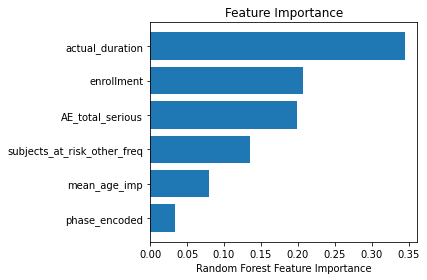

In [59]:
# Plot feature importance

importance = rfr.feature_importances_
idxs = np.argsort(importance)

# Get the names of your columns
column_names = x.columns

plt.title("Feature Importance")
plt.barh(range(len(idxs)), importance[idxs], align="center")
plt.yticks(range(len(idxs)), [column_names[i] for i in idxs])  
plt.xlabel("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

Hyperparameter tuning

In [60]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],  # Maximum depth of the tree
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'] # The function to measure the quality of a split.
}


# Instantiate GridSearchCV
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit data
grid_search.fit(x_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Best parameters: {'criterion': 'squared_error', 'max_depth': 3}
R-squared: 0.40192251284383596
Mean Absolute Error: 7.080633631034837
Mean Squared Error: 157.5690223389906
Root Mean Squared Error: 12.552650012606525


XGBoost
- Hyperparameter tuning

In [61]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7], # Maximum depth of a tree.
    'learning_rate': [0.01, 0.1, 0.3], # Step size shrinkage used in update to prevents overfitting. 
    'n_estimators': [100, 150, 200], # The number of trees in the boosting algorithm.
    'subsample': [0.5, 0.7, 0.9], # Subsample ratio of the training instances. 
    'colsample_bytree': [0.5, 0.7, 0.9] # Subsample ratio of columns when constructing each tree.
}

# Instantiate XGBoost regressor
xgb_model = xgb.XGBRegressor()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the data
grid_search.fit(x_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
R-squared: 0.42126657136436685
Mean Absolute Error: 7.039227897851225
Mean Squared Error: 152.47265196122987
Root Mean Squared Error: 12.347981695857419


In [64]:
# Save the DataFrame to a CSV file

df_streamlit = df_ml[['enrollment', 'actual_duration', 'AE_total_serious' ,'mean_age_imp', 'phase_encoded', 'dropout_rate']]
#df_streamlit.to_csv('./data/df_streamlit.csv', index=False)

In [66]:
# Read ML file
file_path = './data/df_streamlit.csv'
df_streamlit = pd.read_csv(file_path)

# Select variables
x =  df_streamlit.drop(columns=['dropout_rate'], axis=1)
y = df_streamlit['dropout_rate']

#Validation chunk size
val_size = 0.20

#Split the data into chunks
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=val_size, random_state = 42)

# Initialize the Random Forest
rfr = RandomForestRegressor(max_depth=7)

# Train the Random Forest on the training data
rfr.fit(x_train, y_train)

# Print R-squared scores on training and test data
r_squared_train = rfr.score(x_train, y_train)
r_squared_test = rfr.score(x_test, y_test)

print(f'Train set R-squared: {r_squared_train}')
print(f'Test set R-squared: {r_squared_test}')

# Make predictions on test data
y_pred = rfr.predict(x_test)

# Evaluate on test data
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Save the trained model using pickle
with open('model.pkl', 'wb') as model_file:
    pickle.dump(rfr, model_file)

Train set R-squared: 0.658645877193237
Test set R-squared: 0.5333195789097427
Mean Absolute Error: 6.730543119936427
Mean Squared Error: 122.95125510507596
Root Mean Squared Error: 11.088338699060197


In [73]:
# Create a DataFrame with specific values
test_data = pd.DataFrame({
    'enrollment': [245],
    'actual_duration': [5],
    'AE_total_serious': [20],
    'mean_age_imp': [41],
    'phase_encoded'   : [0]
})


# Load the trained model
file_path = './data/df_streamlit.csv'  
df_streamlit = pd.read_csv(file_path)
x = df_streamlit.drop(columns=['dropout_rate'], axis=1)
y = df_streamlit['dropout_rate']
rfr = RandomForestRegressor(max_depth=7)
rfr.fit(x, y)

# Make predictions on the test data
dropout_rate_prediction = rfr.predict(test_data)

print("Predicted dropout rate:", dropout_rate_prediction[0])

Predicted dropout rate: 4.755609802898256
